In [94]:
import numpy as np
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
from matplotlib import rc
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [95]:
GESTURES = [
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
    "K", "L","M", "N", "O", "P", "Q", "R", "S", "T",
    "U", "V","W", "X", "Y", "Z", "idle"
]

g = 9.81
column_mapping = {
    'column_0': 'ax',
    'column_1': 'ay',
    'column_2': 'az',
    'column_3': 'gx',
    'column_4': 'gy',
    'column_5': 'gz',
}

NUM_OF_RECORDINGS = 400
dfs_train = []
dfs_validate = []
dfs_test = []
for label in GESTURES:
    for i in range(NUM_OF_RECORDINGS):
        df_train = pd.read_csv(f"csv/official/{label}/{label}_{i}.csv")
        df_train = df_train.rename(columns=column_mapping)
        df_train = df_train.iloc[9:85]
        df_train['label'] = label
        #normalize data by adding 4g to accelerometer data and divide by 8g
        df_train['ax'] = (df_train['ax'] + 4*g) / (8*g)
        df_train['ay'] = (df_train['ay'] + 4*g) / (8*g)
        df_train['az'] = (df_train['az'] + 4*g) / (8*g)
        #normalize data by dividing by 2000 deg/s
        df_train['gx'] = (df_train['gx'] + 2000) / 4000
        df_train['gy'] = (df_train['gy'] + 2000) / 4000
        df_train['gz'] = (df_train['gz'] + 2000) / 4000
        if i < 320:
            dfs_train.append(df_train)
        else:
            dfs_test.append(df_train)
df_train = pd.concat(dfs_train)
df_test = pd.concat(dfs_test)

print (df_train.shape)

(595169, 7)


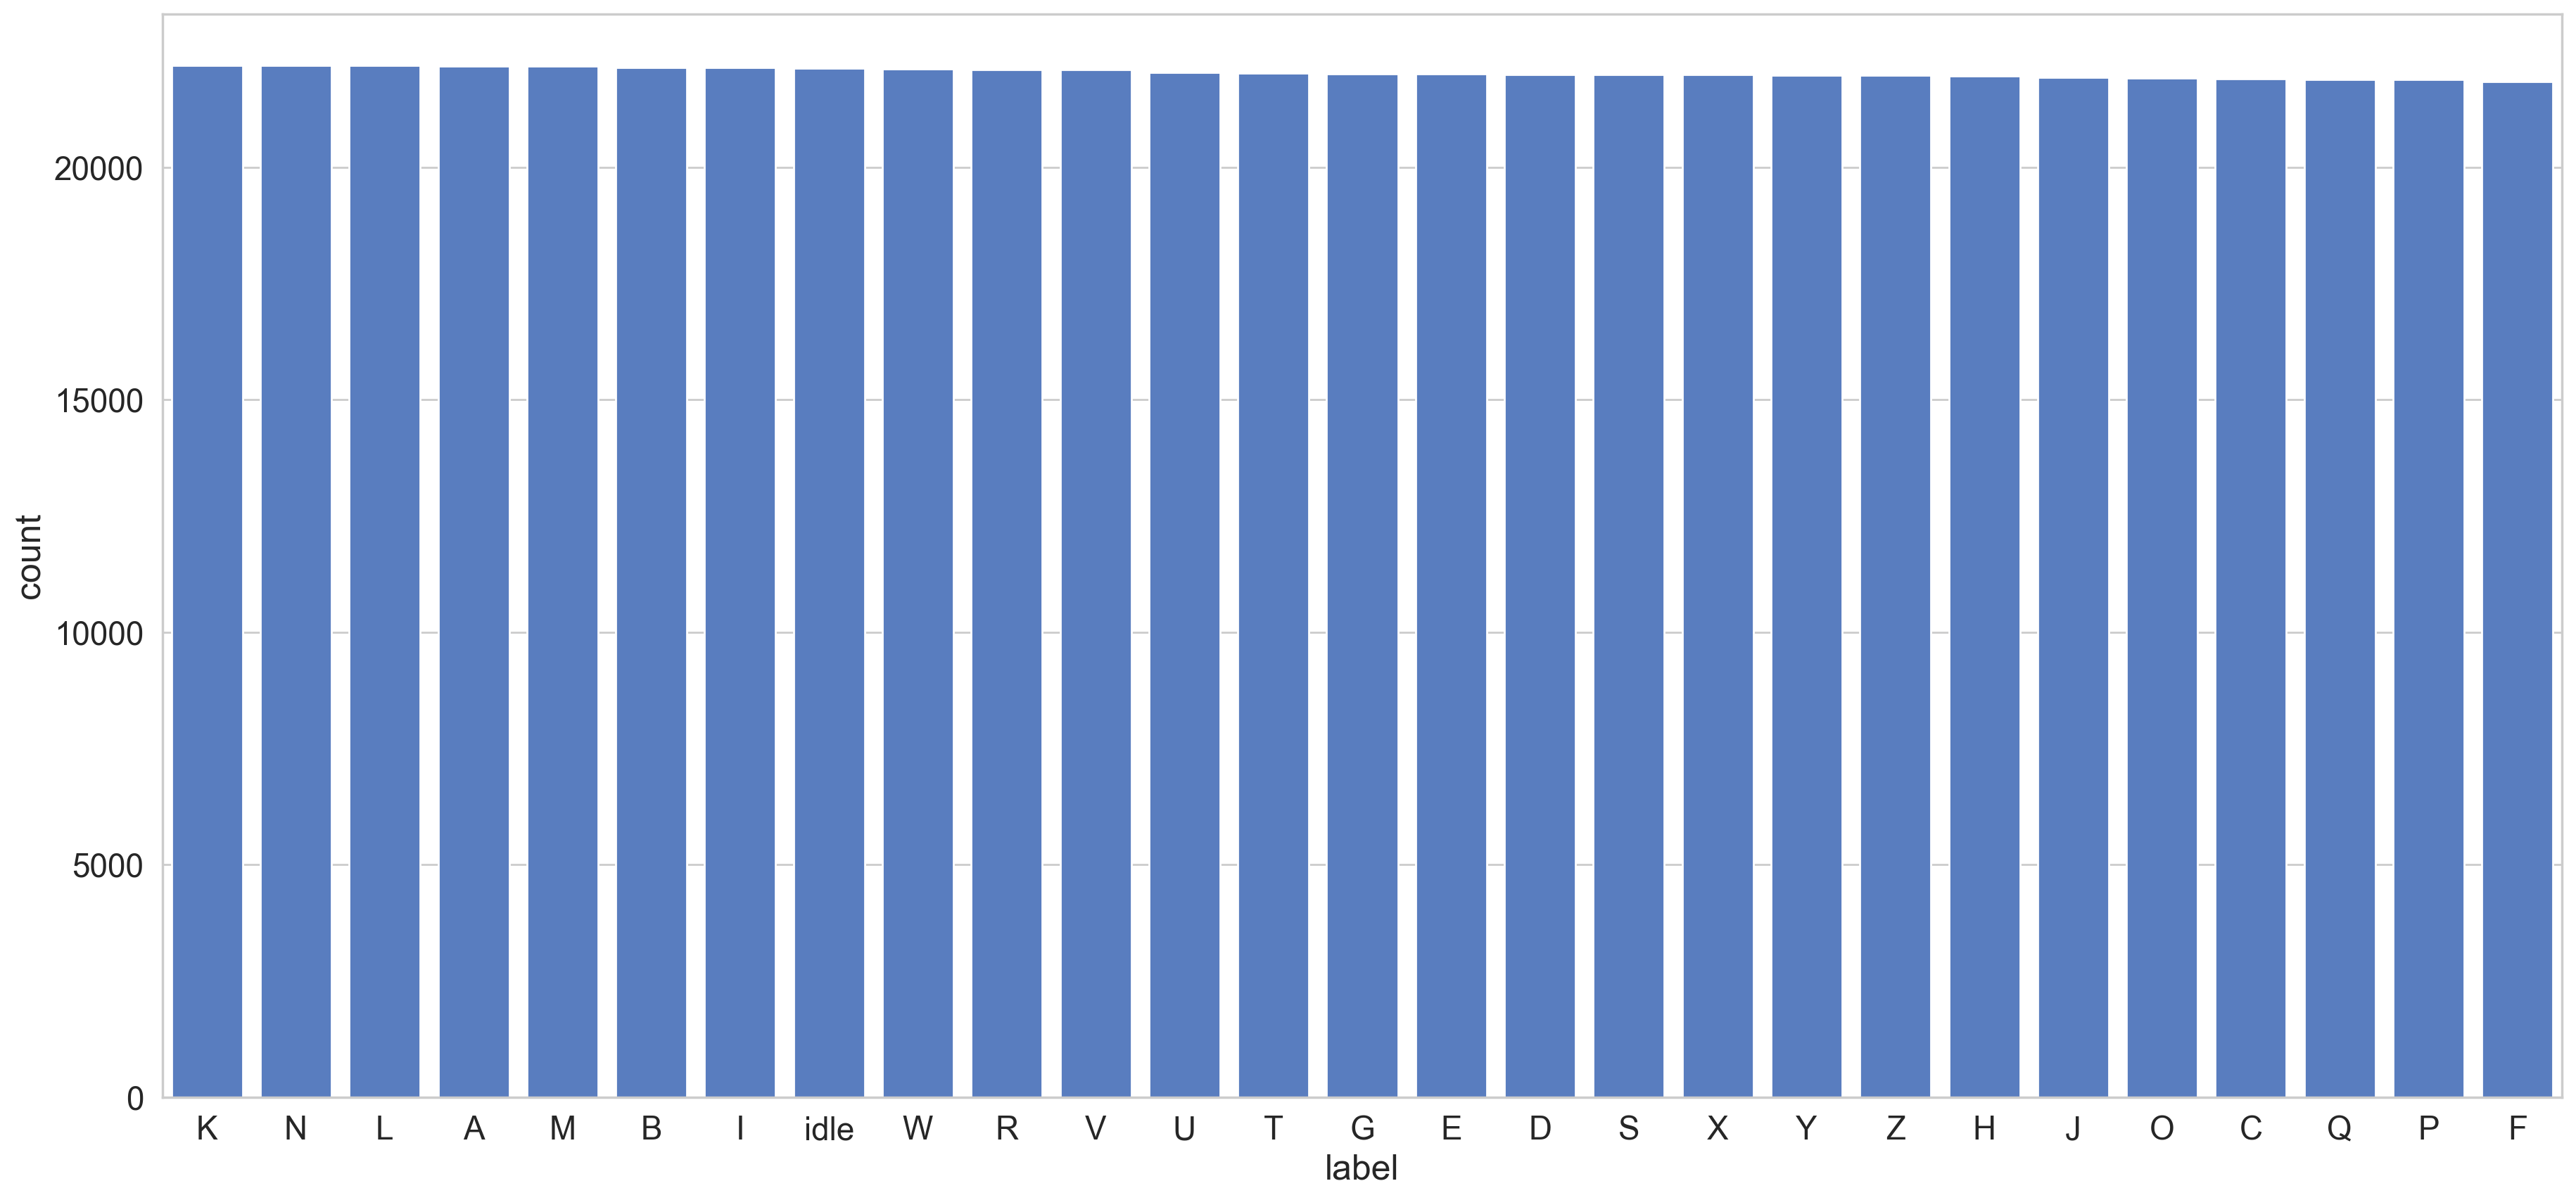

In [96]:
sns.countplot(x = 'label',
              data = df_train,
              order = df_train.label.value_counts().index);

In [97]:
def plot_label(label, df_train):
    data = df_train[df_train['label'] == label][['ax', 'ay', 'az','gx','gy','gz']][:70]
    axis = data.plot(subplots=True, figsize=(16, 12), title=label)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [98]:
# for label in GESTURES:
#     plot_label(label, df_train)

In [99]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaling_columns = ['ax', 'ay', 'az','gx','gy','gz']

df_train[scaling_columns] = scaler.fit_transform(df_train[scaling_columns])


In [100]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(np.unique(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 140
STEP = 20

X_train, y_train = create_dataset(
    df_train[['ax', 'ay', 'az', 'gx', 'gy', 'gz']], 
    df_train.label, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['ax', 'ay', 'az', 'gx', 'gy', 'gz']], 
    df_test.label, 
    TIME_STEPS, 
    STEP
)

In [101]:
print(X_train.shape, y_train.shape)

(29752, 140, 6) (29752, 1)


In [102]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [103]:
print(X_train.shape, y_train.shape)

(29752, 140, 6) (29752, 27)


In [109]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [110]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.3,
    shuffle=True
)

Epoch 1/20
326/326 [==============================] - 79s 231ms/step - loss: 0.0606 - acc: 0.1957 - val_loss: 0.0741 - val_acc: 0.0000e+00
Epoch 2/20
 76/326 [=====>........................] - ETA: 52s - loss: 0.0583 - acc: 0.2153

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

In [ ]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)